In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

import vjp.data as data

## Data distribution

In [2]:
second_instance_samples = data.load_second_instance()

Samples are parsed as Python XML element trees. Queries can be done per-element through [the XPath syntax](https://docs.python.org/3/library/xml.etree.elementtree.html#supported-xpath-syntax). `vjp.data.findall` permits querying an entire list. All results from all queries are added to an output list.

In [3]:
print('Number of instances', len(second_instance_samples))
print('Number of second instance requests',
      len(data.findall(second_instance_samples, ".//partreq[@G='2']/req")[0]))

decisions, decision_mapping = data.findall(second_instance_samples,
                                           ".//courtdec[@G='2']/dec")
upheld, _ = data.findall(decisions, ".[@E='1']")
rejected, _ = data.findall(decisions, ".[@E='0']")
print('Number of second instance decisions', len(decisions))
print('Of which upheld', len(upheld))
print('Of which rejected', len(rejected))
print('Other outcomes', len(decisions) - len(upheld) - len(rejected))

Number of instances 219
Number of second instance requests 480
Number of second instance decisions 249
Of which upheld 110
Of which rejected 135
Other outcomes 4


Exploring requests IDS, claims and arguments to get a full picture of their interconnections shows that some values can be `None` and tagnames are not always consistent. Malformed statements could maybe be manually repaired, but they will be simply ignored for now.

In [4]:
reqs, _ = data.findall(second_instance_samples,
                       ".//partreq[@G='2']/req")
print('Request IDs', set(req.get('ID') for req in reqs), '\n')

claims, _ = data.findall(second_instance_samples,
                         ".//partreq[@G='2']/claim")
print('Claim PROs', set(claim.get('PRO') for claim in claims), '\n')

args, _ = data.findall(second_instance_samples,
                       ".//partreq[@G='2']/arg")
print('Arg PROs', set(arg.get('PRO') for arg in args), '\n')


Request IDs {'Req3bis', 'Req21', 'Req1', 'Req4', 'Req6', 'Req9', 'Req30', 'Req11', 'Req7', 'Req5', 'Req2bis', 'Req3', 'Req2', 'Req10', 'Req8', 'Req20'} 

Claim PROs {'Costreq1', 'Req6', 'Req3|Req4|Req5', 'Req7', 'Req3|Req4', 'Req3', 'Req20', None, 'Req5', 'Req2bis', 'Req2|Req3', 'Req11', 'Req8', 'Req21', 'Req1', 'Req4', 'Req4|5', 'Req2', 'Req10'} 

Arg PROs {'Claim4bis', 'Claim15', 'Claim13', 'Claim6bis', 'Claim1|Claim2', 'Claim1|Claim2|Claim3', 'Claim5', 'Claim7', 'Claim8', 'Claim3', 'Claim1', 'Claim12', 'Claim2', 'Claim11', 'Claim20', 'Claim21', 'Claim14', 'Claim4', None, 'Claim3bis', 'Req5', 'Claim6', 'Req4', 'Claim10', 'Claim3|Claim4', 'Claim9'} 



Some decisions reference multiple requests. A decision that implies the result of multiple requests may be later splitted.

Some decisions reference claims. This shall be investigated (do they imply a label for some given requests?). The number is relatively small, they could be ignored. 

In [5]:
objects = tuple(map(lambda x: x.get('O'), decisions))
print(set(objects))
print('Number of claim objects: ',
      len(tuple(filter(lambda s: not s.startswith('Req'), objects))))

{'Req1', 'Req4', 'Req6', 'Claim2', 'Claim5', 'Req4|Req5', 'Req3|Req4|Req5', 'Claim4', 'Req2|Req5', 'Req2|Req3', 'Req1|Req2', 'Claim3', 'Claim1', 'Req5', 'Req3', 'Req2', 'Req10', 'Req20'}
Number of claim objects:  6


Given the very low amount of different outcomes, the problem will be treated as a binary classification one. Labels are not perfectly balanced.

(array([110.,   0.,   0., 135.,   0.,   0.,   3.,   0.,   0.,   1.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

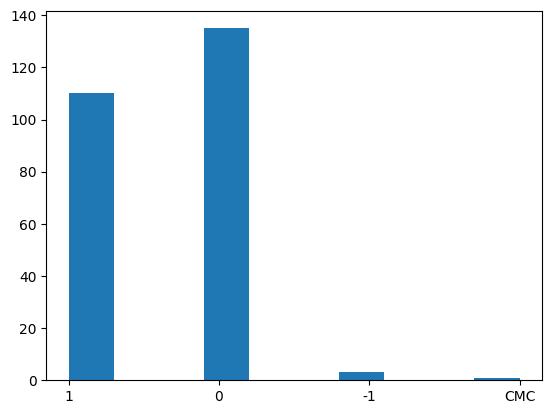

In [6]:
plt.hist(tuple(map(lambda x: x.get('E'), decisions)))

Other outcomes can be dropped.

In [7]:
decisions = upheld + rejected
second_instance_samples = list(set(decision_mapping[decision]
                                   for decision in decisions))

Data will need some processing and handling of special cases. Some values can be `None` (empty tags?).

In [8]:
for decision in decisions[:10]:
    print(decision.text, '\n')

Accoglie l'appello e, in riforma della sentenza impugnata, rigetta il ricorso 
    della contribuente  

La sezione pronunciando sull’appello proposto dal contribuente e dall'Ufficio avverso la sentenza 63/04/2009 emanata dalla Commissione Tributaria Provinciale de L'Aquila così provvede:

		Accoglie parzialmente l’appello del contribuente, limitatamente alla correzione dell'errore materiale, 

In parziale accoglimento sia dell'appello principale che dell'appello incidentale ed
    inconseguente parziale riforma della decisione impugnata, dichiara la legittimità del
    recupero a tassazione della somma portata a credito d'imposta; 

determina in complessivi €23.227,05 i recuperi per l'anno 2004; 

dichiara la illegittimità dei recuperi effettuati per i
    servizi svolti ad opera della “Tennis Club SC” e del giornale “LN”. 

None 

Questa Commissione Tributaria Regionale accoglie l’appello della E S.r.l. 
        riconoscendo legittima l’istanza di rimborso avanzata dalla stessa alla 

Some elements have multiple links. It is particularly interesting when it happens in decision tags, as each decision-request pair can form a new data sample. Iterative filtering and extraction of multiple links makes it possible to explore the whole "tree" of connections between nodes in the document, starting from decision tags and ending wherever it is decided.
A minimal set of features would be: request, arguments and claim tags, labeled by the corresponding decision tag, as defined by [Galli et. al, 2022].

In [9]:
multiple_link_decisions = tuple(filter(lambda e: '|' in e.get('O'), decisions))
print('Number of multilinked decisions', len(multiple_link_decisions))

Number of multilinked decisions 12


## Graph tag representation

To facilitate the task of composing different feature sets based on how they are linked, each document is flattened into a set of triples, then used to build a graph.

In [10]:
triples_dfs = [data.build_tag_triples(sample)
               for sample in second_instance_samples]

In [11]:
print(triples_dfs[0].shape)
triples_dfs[0].head()

(8, 3)


,source,target,edge
0,Dec2,Find1,D
1,Find1,Claim1,O
2,Claim1,Req4,PRO
3,Dec2,Req4,O
4,Costdec1,Costfind1,D


A rapid check for null values (the builder function comes without warranty)

In [12]:
check_null_list = [df.isnull().values.any() for df in triples_dfs]
print(any(check_null_list))

False


In [13]:
graphs = [nx.from_pandas_edgelist(triples, edge_attr='edge',
                                  create_using=nx.DiGraph())
          for triples in triples_dfs]
len(graphs)

216

Let us show one document in graph form.

Connected components ({'Req4', 'Dec2', 'Arg1', 'Claim3', 'Claim1', 'Mot2', 'Req2'}, {'A5', 'A3', 'A8', 'A10', 'A1', 'A4', 'A2', 'A6', 'A7'}, {'Costreq1', 'Costdec1', 'Costfind1'})


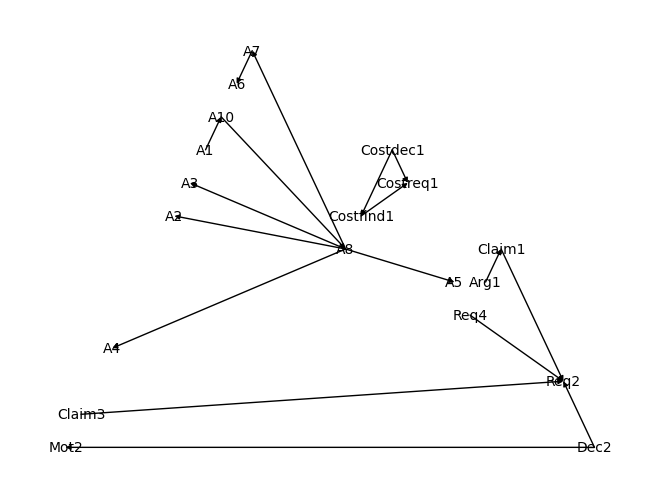

In [14]:
graph = graphs[2].copy()

# Remove initial uninformative components
# for component in tuple(nx.connected_components(graph.to_undirected())):
#     if len(component) <= 2:
#         graph.remove_nodes_from(tuple(component))

# Remove finds for a cleaner representation
for node in tuple(graph.nodes):
    if node.lower().startswith('find'):
        graph.remove_node(node)

print('Connected components',
      tuple(nx.connected_components(graph.to_undirected())))

graph_pos = nx.planar_layout(graph)
nx.draw(graph, pos=graph_pos, node_size=0, font_size=10, with_labels=True,
        arrowsize=7)

Graph representation suggests that related parts of the document (i.e. a request and its associated decision, arguments, etc.) are identified by connected components. The final configuration for the dataset is then built by looking at these components. Ideally, each connected component leads to one sample, i.e. one decision and all the related parts.
Multiple requests are split into multiple samples, keeping however the same related tags.

In [15]:
df = data.dataframe_from_graphs(graphs, second_instance_samples)
print(df.shape)
df.head()

(306, 6)


,document_index,fact,req,arg,claim,label
0,0,"Da ultimo l’Agenzia delle Entrate, Direzione P...","Da ultimo l’Agenzia delle Entrate, Direzione P...",,dando atto della regolarità della domanda di d...,1
1,1,Per quanto sopra l’Ufficio ha concluso chieden...,Per quanto sopra l’Ufficio ha concluso chieden...,,,1
2,2,L'Agenzia ha impugnato la decisione,"L'Agenzia ha impugnato la decisione L'Agenzia,...",premettendo che la sanzione nei confronti dell...,"La EAI S.p.A. si è costituita in giudizio, dep...",1
3,2,"L'Agenzia, che ha prodotto numerose sentenze d...","L'Agenzia ha impugnato la decisione L'Agenzia,...",premettendo che la sanzione nei confronti dell...,"La EAI S.p.A. si è costituita in giudizio, dep...",1
4,3,ed ha spiegato appello incidentale,ed ha spiegato appello incidentale Avverso la ...,e ritiene che la prova della sottofatturazione...,a) Con il primo motivo dell’appello principale...,0


# References


[Galli et. al, 2022]: Galli, F., Grundler, G., Fidelangeli, A., Galassi, A., Lagioia, F., Palmieri, E., Ruggeri, F., Sartor, G., & Torroni, P. (2022). Predicting outcomes of Italian VAT DECISIONS1. *Frontiers in Artificial Intelligence and Applications*. https://doi.org/10.3233/faia220465   